In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bourn23","key":"1acecc1aaacbd1feb67341e71bac006b"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# ! kaggle datasets list

In [8]:
# ! kaggle competitions download -c 'name-of-competition'
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification/

 98% 721M/736M [00:08<00:00, 144MB/s]
100% 736M/736M [00:08<00:00, 90.5MB/s]


In [ ]:
!unzip eye-diseases-classification.zip -d eye-diseases-classification

## Setup Model (for retina training)

In [59]:
# ref: https://www.kaggle.com/code/bourn23/the-power-of-transfer-learning/
# ref: https://www.kaggle.com/code/ahmedmohsen2002/the-power-of-transfer-learning/notebook
# dataset:

In [9]:
import tensorflow as tf

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [11]:
from tensorflow.keras.applications import EfficientNetB3

In [12]:
def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max')
    effnet.trainable=False

    for layer in effnet.layers[83:]:
      layer.trainable=True

    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)
    output=Dense(4, activation='softmax')(x)

    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# some extra imports

from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers

In [14]:
model = make_model()

43941136/43941136 [==============================] - 0s 0us/step


### Setup data loaders

In [19]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = './eye-diseases-classification/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)


Found 4217 files belonging to 4 classes.


In [20]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = diabetic_retinopathy, 2 = glaucoma, 3 = normal, 

### Preprocess image

In [21]:
data = data.map(lambda x, y: (x/255, y))

In [22]:
sample = data.as_numpy_iterator().next()

In [23]:
print("Total number of batchs = ",len(data))

Total number of batchs =  66


In [24]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [25]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [26]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 47, # validate batchs = 13, # test batch = 6


66

In [27]:
## Test Set

test_iter = test.as_numpy_iterator()

In [29]:
import numpy as np

In [30]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [31]:
y_true = test_set['labels']

### Train model

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [33]:
from keras import callbacks
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 50,
    callbacks=[early_stop],
)

Epoch 1/50
47/47 [==============================] - 113s 1s/step - loss: 18.7592 - accuracy: 0.6134 - val_loss: 15.1804 - val_accuracy: 0.3149
Epoch 2/50
47/47 [==============================] - 72s 1s/step - loss: 12.2262 - accuracy: 0.7653 - val_loss: 10.8888 - val_accuracy: 0.3450
Epoch 3/50
47/47 [==============================] - 51s 1s/step - loss: 8.6930 - accuracy: 0.8118 - val_loss: 8.0902 - val_accuracy: 0.3822
Epoch 4/50
47/47 [==============================] - 71s 1s/step - loss: 6.3393 - accuracy: 0.8288 - val_loss: 6.0285 - val_accuracy: 0.4579
Epoch 5/50
47/47 [==============================] - 51s 1s/step - loss: 4.6788 - accuracy: 0.8467 - val_loss: 4.5174 - val_accuracy: 0.5721
Epoch 6/50
47/47 [==============================] - 51s 1s/step - loss: 3.4823 - accuracy: 0.8733 - val_loss: 3.3834 - val_accuracy: 0.6947
Epoch 7/50
47/47 [==============================] - 51s 1s/step - loss: 2.6821 - accuracy: 0.8670 - val_loss: 2.7629 - val_accuracy: 0.6611
Epoch 8/50
47/4

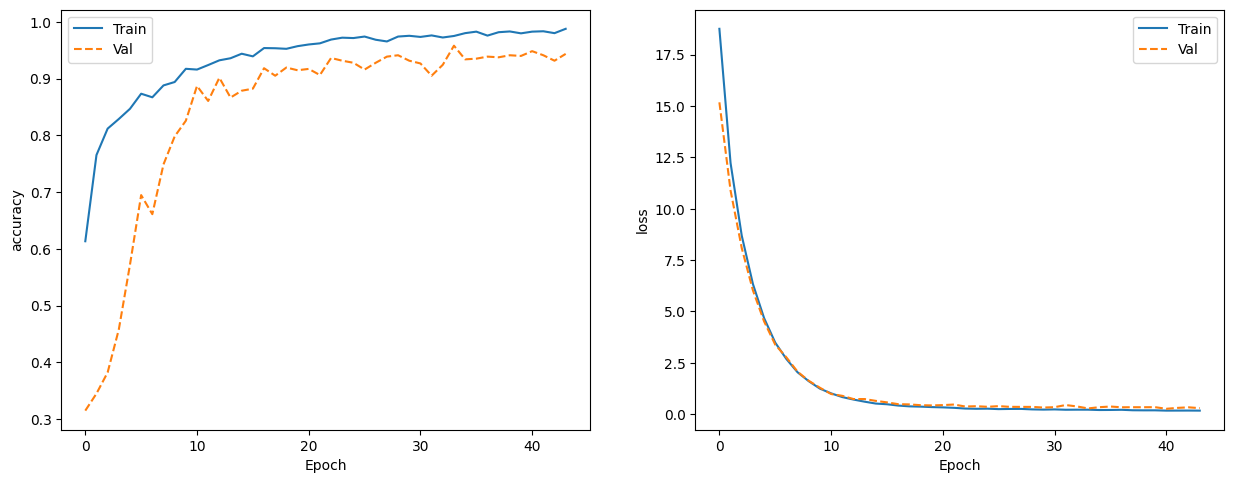

In [35]:
import matplotlib.pyplot as plt

# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()



plot_his(history)

In [36]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

12/12 [==============================] - 10s 211ms/step


In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.99      0.94      0.96       100
diabetic_retinopathy       1.00      1.00      1.00        97
            glaucoma       0.91      0.95      0.93        91
              normal       0.90      0.92      0.91        89

            accuracy                           0.95       377
           macro avg       0.95      0.95      0.95       377
        weighted avg       0.95      0.95      0.95       377



In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [48]:
class_names_ = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

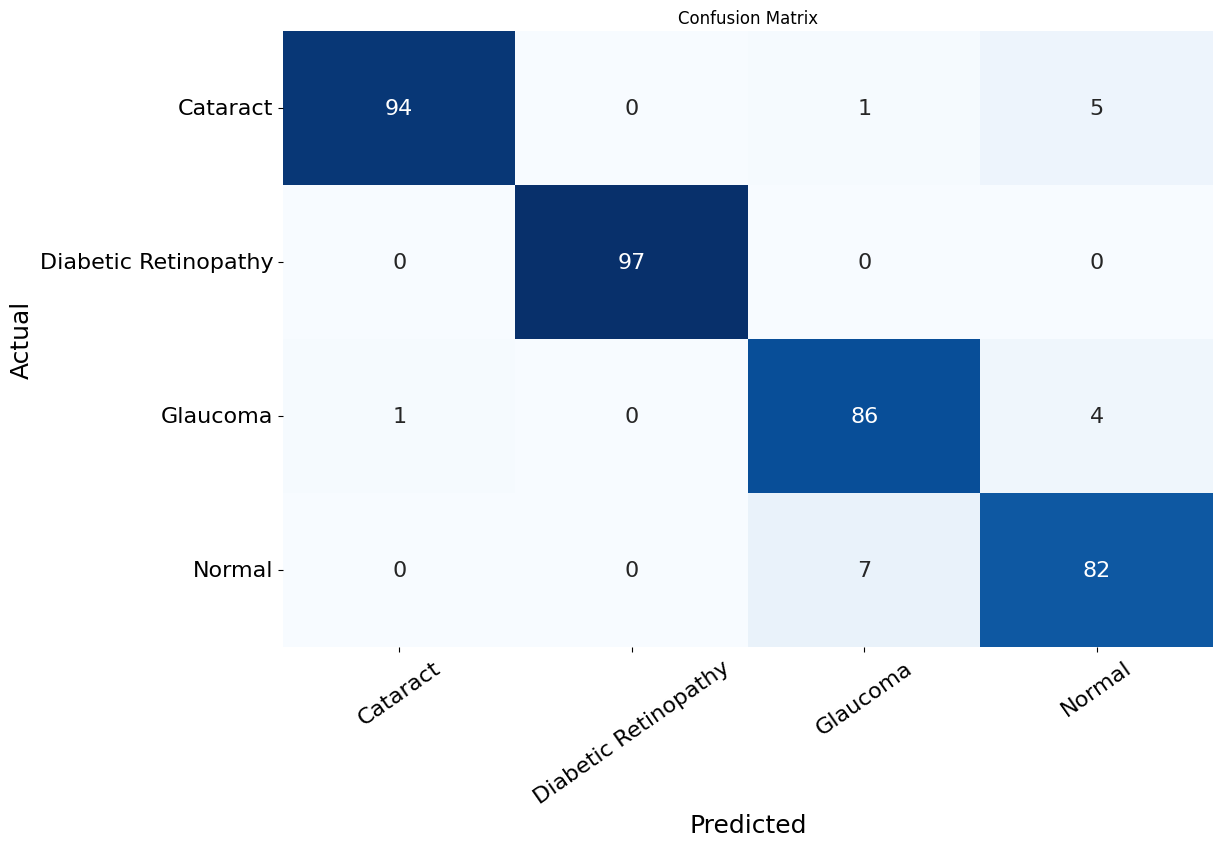

In [53]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names_, rotation=35, fontsize = 16)
plt.yticks(np.arange(4)+.5, class_names_, rotation=0, fontsize = 16)
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel("Actual", fontsize = 18)
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.pdf', bbox_inches = 'tight', transparent = True)


In [54]:
model.save("EffNetB3_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
model.save("/content/drive/MyDrive/hackpsu_fa2023/EffNetB3_model")

In [56]:
# ref: https://learningmaterialcomputations.medium.com/save-any-file-from-google-colab-to-your-google-drive-caf8291ba59b#:~:text=Step%201%3A%20Mount%20your%20google,that%20you're%20working%20with.&text=Step%202%3A%20Authorise%20Google%20Colab,the%20%E2%80%9CCopy%20Path%E2%80%9D%20option.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
!cp EffNetB3_weights.h5 /content/drive/MyDrive/hackpsu_fa2023/EffNetB3_weights.h5

In [64]:
!cp eye-diseases-classification -r /content/drive/MyDrive/hackpsu_fa2023/eye-images/

### Export to TF Lite

In [60]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [61]:
# Save the converted model to a .tflite file
with open("retina_scanner.tflite", "wb") as f:
    f.write(tflite_model)

In [65]:
# Load the TensorFlow Lite model into an interpreter
interpreter = tf.lite.Interpreter(model_path="retina_scanner.tflite")
interpreter.allocate_tensors()

In [82]:
results = []

for image in test_set['images'][:10]:
    # Prepare input data (reshape and preprocess a single image)
    input_data = image.astype(np.float32)  # Ensure it has the correct shape (224, 224, 3)

    # Set input tensor data
    interpreter.set_tensor(input_details[0]['index'], [input_data])

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Use the output data (e.g., post-process and analyze results)
    results.append(np.argmax(output_data, 1))


In [83]:
results

[array([1]),
 array([0]),
 array([2]),
 array([0]),
 array([2]),
 array([0]),
 array([3]),
 array([0]),
 array([3]),
 array([2])]